

# Practical 5b: Generative Adversarial Network

© Machine Learning Summer School - Telkom University

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%205/MLSS2020TU%20-%20Practical%205b.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
    
</td><td>
<a href="https://github.com/adf-telkomuniv/MLSS2020_Telkom/blob/master/practical%205/MLSS2020TU%20-%20Practical%205b.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>

# Generative Adverserial Network


In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). 

As you've tried before, another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with Variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

<br>

Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train 


Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! 2017 is said to be the year of GAN with so many research and papers published in investigating and improving GANs application. 

Several popular GAN architectures and implementation are: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028), [CGAN](https://arxiv.org/abs/1411.1784), [InfoGAN](https://arxiv.org/abs/1606.03657), [Pix2Pix](https://arxiv.org/abs/1611.07004), [CycleGAN](https://arxiv.org/abs/1703.10593), and many others.

---
## GAN Networks

In a GAN, we build two different neural networks. 

Our first network is a traditional classification network, called the **DISCRIMINATOR**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). 

Our other network, called the **GENERATOR**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

<center>
<img src="https://i.ibb.co/4RyZ2Vr/gan-en.png" width=80% />
</center>
<br>

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where 
* $z \sim p(z)$ are the random noise samples,
* $G(z)$ are the generated images using the neural network generator $G$, and
* $D$ is the output of the discriminator, specifying the probability of an input being real.

<br>

In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

---
## GAN Training
Inside the training loop, there are basically three steps to train GANs.


<center>
<img src="https://i.ibb.co/Y388bJb/gan-steps-en.png" width=80% />
</center>
<br>

First, in each iteration, we use the current Generator to generate new batch of fake data from random latent space. Then the second is we use the generated batch along with a real batch of data to train one step of the Discriminator Model (one time forward and backward pass). The objective here is to minimize the binary crossentropy loss between the fake and real class.

The last is to train the Generator Model by feeding in a batch of random latent space to generate a batch of fake data (forward pass). The batch of fake data then feed into the trained Discriminator from previous step (forward pass). The objective here is to maximize the wrongly classified data, which we can turn into minimizing correctly classified data. The loss is then used to update **ONLY** the Generator Model's weights (backward pass)


---
# [Part 1] Import Libraries and Load Data

---
## Import Libraries

Import requiered libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

import os, time, glob, imageio, PIL
from IPython.display import Image

# from PIL import Image

---
## Load MNIST Dataset

Again, here we're going to use the simple MNIST Dataset. You can try with other MNIST-like dataset like before.

Also, we don't really need the test split in GAN, so here we combine them

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


X_train = np.concatenate([X_train, X_test])

11493376/11490434 [==============================] - 0s 0us/step



It is recommended to use the **hyperbolic tangent** activation function as the output from the generator model.

As such, it is also recommended that real images used to train the discriminator are scaled so that their pixel values are in the range `[-1,1]`. This is so that the discriminator will always receive images as input, real and fake, that have pixel values in the same range.

In [3]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]

---
## Helper Functions

In [4]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [5]:
def generate_images(g, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = tf.random.normal(shape=(batch_size, z_size))
    generated_images = g.predict(noise, verbose=1)
    image = combine_images(generated_images)
    filename = "generated_image.png"
    image = image*127.5+127.5
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

In [6]:
def generate_best_images(g, d, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = tf.random.normal(shape=(batch_size*20, z_size))

    generated_images = g.predict(noise, verbose=1)
    d_pret = d.predict(generated_images, verbose=1)

    index = np.arange(0, batch_size*20)
    index.resize((batch_size*20, 1))

    pre_with_index = list(np.append(d_pret, index, axis=1))
    pre_with_index.sort(key=lambda x: x[0], reverse=True)

    nice_images = np.zeros((batch_size,) + generated_images.shape[1:3], dtype=np.float32)
    nice_images = nice_images[:, :, :, None]

    for i in range(batch_size):
        idx = int(pre_with_index[i][1])
        nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]

    image = combine_images(nice_images)
    filename = "generated_image_best.png"
    image = image*127.5+127.5
    PIL.Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

In [7]:
def show_gif(base_dir, anim_file): 

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(base_dir+'/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            for i in range(3):
              writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

    print('GIF saved as', anim_file)

    with open(anim_file,'rb') as f:
      display(Image(data=f.read(), format='png'))

## Define Model

### Generator Model

In [8]:
def generator_model(latent_dim = 128):
    model = Sequential([
        Dense(1024, input_dim=latent_dim, activation='relu'),
        BatchNormalization(),
        Dense(7 * 7 * 128, activation='relu'),
        Reshape((7, 7, 128)),
        Conv2DTranspose(64, (4, 4), strides=(2,2), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2DTranspose(1, (4, 4), strides=(2,2), padding='same', activation='tanh'),
    ])
    return model

generator_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1

### Discriminator Model

In [9]:
def discriminator_model():
    model = Sequential([
        Conv2D(32, (5, 5), input_shape=(28, 28, 1), padding='same'),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (5, 5)),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(4 * 4 * 64, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

### GAN = Generator + Discriminator

In [10]:
def combine_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

## Training Functions


In [11]:
def train_gan(X_train, Y_train, batch_size, epochs, g, d, save_every=500, print_every=100):
    
    start = time.time()


    z_size = g.layers[0].input_shape[1]
    

    d_optim = Adam(learning_rate=0.0003, beta_1=0.5)
    g_optim = Adam(learning_rate=0.0003, beta_1=0.5)

    d.trainable = False 
    d_on_g = combine_model(g, d)
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)


    print("Number of batches", int(X_train.shape[0]/batch_size))
    seed_saved = tf.random.normal(shape=(16, z_size))
    os.mkdir('imgs')
    img_count = 0

    for epoch in range(epochs):
        print("\n-------------------------------\nEpoch is", epoch)        
        
        for index in range(int(X_train.shape[0]/batch_size)):
            
            noise = tf.random.normal(shape=(batch_size, z_size))
            
            generated_images = g.predict(noise, verbose=0)
            
            image_batch = X_train[index*batch_size:(index+1)*batch_size]
            
            if index % save_every == 0:
                for_save = g.predict(seed_saved)
                image = combine_images(for_save)
                image = image*127.5+127.5           

                plt.imshow(image, cmap=plt.get_cmap('gray'))
                filename = 'imgs/image_'+'{:03}'.format(img_count)+'.png'
                plt.axis('off')
                plt.savefig(filename)
                plt.show()
                img_count += 1
                
            X = np.concatenate((image_batch, generated_images))
            y = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            y += 0.05 * tf.random.uniform(tf.shape(y))
            
            d_loss = d.train_on_batch(X, y)           
            
            noise = tf.random.normal(shape=(batch_size, z_size))
            
            d.trainable = False            
            
            y = tf.ones((batch_size, 1))
            g_loss = d_on_g.train_on_batch(noise, y)
            
            if index % print_every == 0: 
                print("batch %d, g_loss : %f, d_loss : %f" % (index, g_loss, d_loss))
            
            d.trainable = True       
            
    end = time.time()

    print((end-start)/60)
        
    return g, d

## Training Process

### Initialize Model

In [12]:
g_model = generator_model()
d_model = discriminator_model()

### Train GAN

In [13]:
batch = 225
epochs = 50
g_model, d_model = train_gan(X_train,y_train, batch, epochs, g_model, d_model)

Output hidden; open in https://colab.research.google.com to view.

## Generate New Images

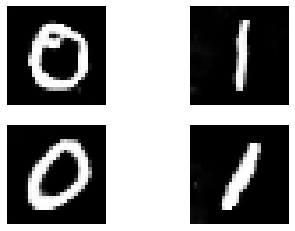

In [14]:
seed = tf.random.normal(shape=(4, 128))
images = g_model.predict(seed)

for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 3ms/step


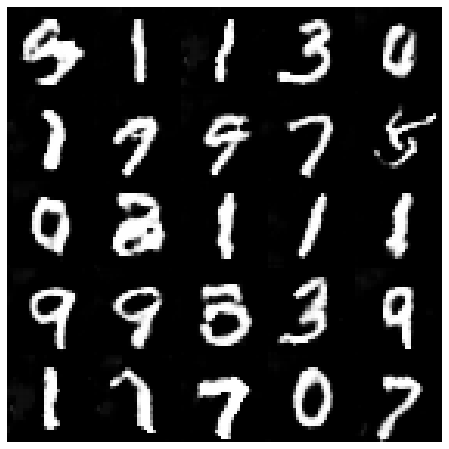

In [15]:
images = generate_images(g_model, 25)
plt.figure(figsize = (8,8))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

16/16 [==============================] - 0s 2ms/step


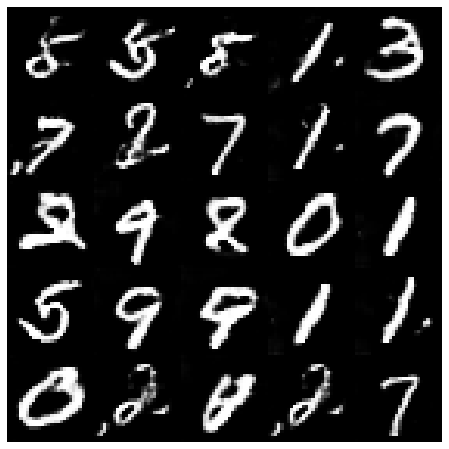

In [16]:
images = generate_best_images(g_model, d_model, 25)
plt.figure(figsize = (8,8))
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [17]:
show_gif('imgs', 'GAN.gif')

Output hidden; open in https://colab.research.google.com to view.

---

# Congratulation

<font size=5> You've Completed Practical 5b</font>

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>